In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pykeen.datasets.hetionet import Hetionet
from scipy import stats
import sys
import os
from pykeen.datasets.base import PathDataset
from pykeen.predict import predict_target
from scipy.stats import kstest
import pickle
from scipy.stats import pearsonr

sys.path.append(os.path.abspath('../src/'))

from utils import get_predictions_tail

In [3]:
# Load the STRING_HPO network edges
df: pd.DataFrame = pd.read_csv(
    "../ELs_for_Rotate/String_HPO_2019.all_hpo/train.txt", sep="\t"
)
df.columns = ["source", "relation", "target"]

# Load these edges into a NX graph and compute the degree for each entity
G: nx.MultiGraph = nx.from_pandas_edgelist(
    df, "source", "target", create_using=nx.MultiGraph()
)
degs: dict = dict(G.degree())

In [4]:
# Load the data
xls = pd.ExcelFile('../Resources/aba3066-table-s2.xlsx')

gene_tissue_counts_female = {}
gene_tissue_counts_male = {}
t2g2s = {'tissue':[],'gene':[],'sex':[]}
tissue_2_gene_by_sex = {}
for sheet_name in xls.sheet_names[2:]:
    xdf = xls.parse(sheet_name)
    for i,row in xdf.iterrows():
        g = row['HUGO_gene_id']
        is_female = row['MASH beta'] > 0
        if is_female:
            if g not in gene_tissue_counts_female:
                gene_tissue_counts_female[g] = 0
            gene_tissue_counts_female[g] += 1
            t2g2s['tissue'].append(sheet_name)
            t2g2s['gene'].append(g)
            t2g2s['sex'].append('female')
        else:
            if g not in gene_tissue_counts_male:
                gene_tissue_counts_male[g] = 0
            gene_tissue_counts_male[g] += 1
            t2g2s['tissue'].append(sheet_name)
            t2g2s['gene'].append(g)
            t2g2s['sex'].append('male')

# build a DF for these that are differentially expressed and with greater expression in females
genes_female = gene_tissue_counts_female.keys()
data_female = {'gene':genes_female,'tissue_count':[gene_tissue_counts_female[g] for g in genes_female]}
df_female = pd.DataFrame(data_female)
df_female['tissue_count'].max()
print('females',df_female[df_female['tissue_count'] == df_female['tissue_count'].max()])
df_female = df_female[df_female['tissue_count'] < 45]
print('females',df_female.shape)

# build a DF for these that are differentially expressed and with greater expression in males
genes_male = gene_tissue_counts_male.keys()
data_male = {'gene':genes_male,'tissue_count':[gene_tissue_counts_male[g] for g in genes_male]}
df_male = pd.DataFrame(data_male)
df_male['tissue_count'].max()
print('males',df_male[df_male['tissue_count'] == df_male['tissue_count'].max()])
df_male = df_male[df_male['tissue_count'] < 45]
print('males',df_male.shape)

# add prefix 'STRING:' to all genes
df_female['gene'] = [ 'STRING:'+x for x in df_female['gene']]
df_male['gene'] = [ 'STRING:'+x for x in df_male['gene']]

genes_female = list(df_female['gene'])
genes_male = list(df_male['gene'])


females    gene  tissue_count
27  NaN           739
females (2433, 2)
males   gene  tissue_count
3  NaN          1090
males (2364, 2)


In [5]:
print(df_female)
print(df_male)

               gene  tissue_count
0       STRING:XIST            44
1      STRING:KDM6A            44
2      STRING:KDM5C            44
3     STRING:EIF1AX            44
4      STRING:RPS4X            44
...             ...           ...
2429   STRING:WDR89             1
2430  STRING:SECTM1             1
2431   STRING:ZNF91             1
2432  STRING:TMEM71             1
2433   STRING:PRDM5             1

[2433 rows x 2 columns]
                  gene  tissue_count
0        STRING:GREB1L            15
1         STRING:ZBED1            42
2          STRING:CD99            44
4          STRING:SGCZ             4
5     STRING:LINC00844            10
...                ...           ...
2360       STRING:ISCU             1
2361    STRING:CAPRIN1             1
2362        STRING:MAF             1
2363       STRING:GPS1             1
2364     STRING:PDGFRB             1

[2364 rows x 2 columns]


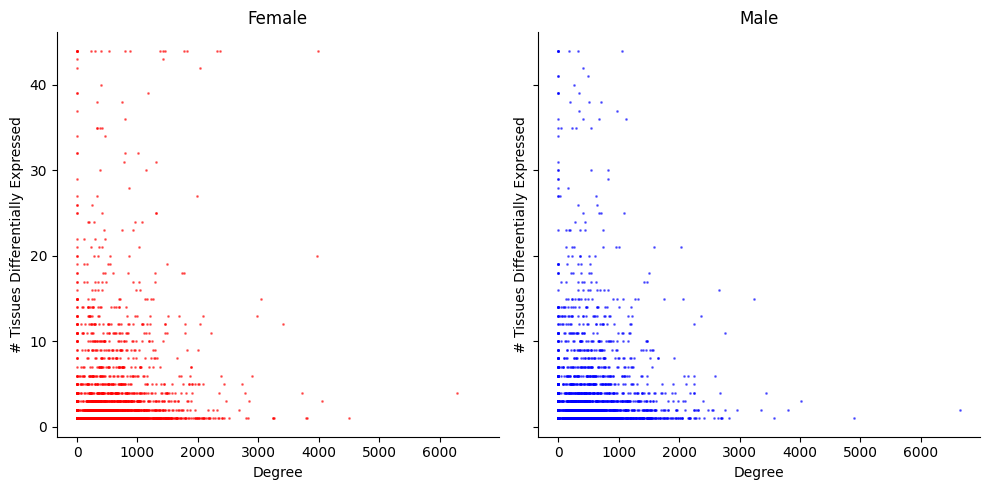

Female Pearson's R= PearsonRResult(statistic=0.016189431381413794, pvalue=0.42475854283030806)
Male Pearson's R= PearsonRResult(statistic=-0.08771738082546912, pvalue=1.9469982046331922e-05)


In [17]:
# plot degree vs # tissues differentially expressed in seporated by sex

df_female['degree'] = [ degs[x] if x in degs else -1 for x in df_female['gene']]
df_male['degree'] = [ degs[x] if x in degs else -1 for x in df_male['gene']]

fig,ax = plt.subplots(1,2,figsize=(10,5), sharey=True, sharex=True)

ax[0].scatter(df_female['degree'],df_female['tissue_count'],label='female',color='red',s=1, alpha=0.5)
ax[0].set_title('Female')

ax[1].scatter(df_male['degree'],df_male['tissue_count'],label='male',color='blue',s=1, alpha=0.5)
ax[1].set_title('Male')

ax[0].set_xlabel('Degree')
ax[0].set_ylabel('# Tissues Differentially Expressed')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel('# Tissues Differentially Expressed')

# remove top and right borders
for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../Figures/diff_expr_degree_vs_tissues.png',dpi=300)
plt.show()

# pearson correlation between degree and # tissues differentially expressed
print('Female Pearson\'s R=',pearsonr(df_female['degree'],df_female['tissue_count']))
print('Male Pearson\'s R=',pearsonr(df_male['degree'],df_male['tissue_count']))


## Olfactory & Other gene groupings

In [ ]:
# load the TSV

gene_group_df = pd.read_csv('../supplementary_dataset_13_gene_lists.tsv',sep='\t')

for group in gene_group_df['gene_list'].unique:
    print(group)
    group_genes = [ 'STRING:' + gene for x in gene_group_df[gene_group_df['gene_list'] == group]['gene']]
    print('Number genes in group:',len(group_genes))
    
    # VS female
    annotated_p = two_group_g2p_ranking_test(prefix=group,
                            hpos_a=group_genes,
                            hpos_b=genes_female,
                            label_a=group,
                            label_b='female',
                            data=data,
                            model=model,
                            degs=degs,
                            train_triples=train_triples,
                            test_triples=test_triples,
                            valid_triples=valid_triples,
                            all_genes=genes,
                            relation='STRING2STRING')

    # VS male
    annotated_p = two_group_g2p_ranking_test(prefix=group,
                            hpos_a=group_genes,
                            hpos_b=genes_male,
                            label_a=group,
                            label_b='male',
                            data=data,
                            model=model,
                            degs=degs,
                            train_triples=train_triples,
                            test_triples=test_triples,
                            valid_triples=valid_triples,
                            all_genes=genes,
                            relation='STRING2STRING')